<h1 style="font-size:30px;">Intersection over Union (IoU)</h1>

In the object detection problems, the goal is to accuractly predict the location of an object within an image with a bounding box that encompasses the boundaries of the object. The metric that is typically used to quanitfy this accuracy is called **Intersection over Union (IoU)**. In this notebook, we will demonstrate how to compute this metric.

<img src="https://opencv.org/wp-content/uploads/2022/05/c4-06-iou-feature-image.png" width="1000">

<center>Reference: <a href="https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=detection&c=%2Fm%2F0bwd_0j">Open Images Datasets</a></center>

## Table of Contents

* [1 Plotting Bounding Boxes](#1-Plotting-Bounding-Boxes)
* [2 Computing IoU](#2-Computing-IoU)
* [3 Computing Overlap](#3-Computing-Overlap)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 10)
import matplotlib.patches as patches
import tensorflow as tf

## 1 Plotting Bounding Boxes

`patches.Rectangle` of `matplotlib` is used to a bounding box. It requires $x_{min}$, $y_{min}$, $width$, and $height$. 

$width$ and $height$ can be calculated as follows:

$$
width = x_{max} - x_{min} + 1 \\
height = y_{max} - y_{min} + 1
$$

**Why is it required to add a 1 after subtracting min from max?**

Since the width and height are represented in terms of pixels, they are not continuous but just discrete numbers. 

The bounding box is represented in the form of $[x_{min}, y_{min}, x_{max}, y_{max}]$. Here, $(x_{min}, y_{min})$ and $(x_{max}, y_{max})$, both pixels are part of the bounding box. 

So starting from $x_{min}$ and $width = x_{max} - x_{min}$ , we can't include pixels where $x = x_{max}$. **Adding one solves the problem**. 

In [26]:
def plot_bounding_box(dbox_data):
    """
    "Plot bounding boxes"
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ] 
    """
    
    # Calculate width and height for all boxes.
    # width = x_max - x_min + 1, x_max column index 2 and x_min column index is 0.
    # height = y_max - y_min + 1, y_max column index 3 and y_min column index is 1
    
    width = dbox_data[:, 2] - dbox_data[:, 0] + 1
    height = dbox_data[:, 3] - dbox_data[:, 1] + 1
    
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    fig = plt.figure(figsize=(15, 15))       
    
    ax = fig.add_subplot(111, aspect='equal')
    
    for i in range(tf.shape(dbox_data)[0]):
        ax.add_patch(
            patches.Rectangle(
                (dbox_data[i, 0], dbox_data[i, 1]),
                width[i],
                height[i],
                fill=False,      # remove background
                color=color[i%len(color)],
                linewidth = 3,
                label = '{}'.format(i)
            ) 
        )
        
    ax.legend()
    
    plt.xticks(range(0, 1050, 50))
    plt.yticks(range(0, 1050, 50))
        
    plt.show()
    
    return

There are four bounding boxes of the format $[x_{min}, y_{min}, x_{max}, y_{max}]$.

In [20]:
# Bounding boxes / detections.
detections = tf.Variable([
    [100, 100, 500, 600],
    [150, 320, 570, 620],
    [50, 150, 450, 800],
    [550, 300, 900, 500]
],
    dtype=tf.float32
)

**Let us plot these bounding boxes.**

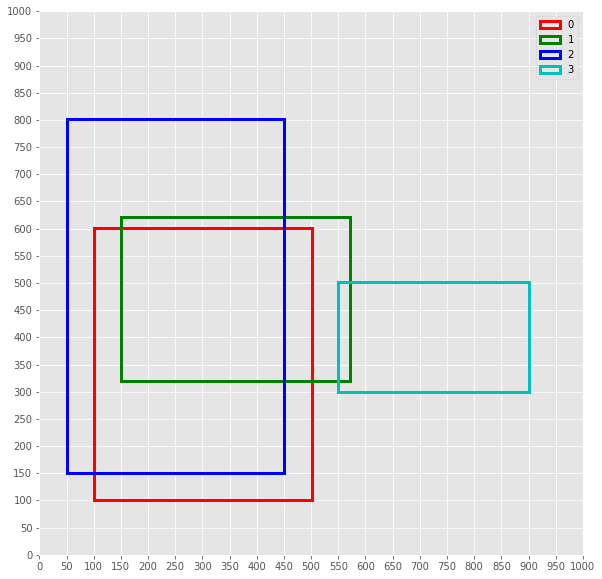

In [21]:
# Plot bounding boxes.
plot_bounding_box(detections)

## 2 Computing IoU

In the code cell below, we define a function that computes the `IoU` of the $0^{th}$ indexed bounding box with the rest of the boxes $(1^{st}, 2^{nd}, ...)$.  This function will be used as a building block in  future notebook non-maximum suppression (NMS). If you are not aleady familair with non-maximum suppression, it will be covered in a subsequent notebook.

**Here is the algorithm that is implemented below to compute the IoU of two bounding boxes:**

- Calculate the `width` and `height` of bounding boxes one and two.


- Calculate `area_bounding_box_1` and `area_bounding_box_2` using the width and height for bounding boxes one and two, respectively.


- Calculate coordinates of the overlapped rectangle of the two bounding boxes.


- Calculate the width and height of the intersection (overlap) using its coordinates.


- Change negative widths and heights to zero. 


- Calculate the area of the intersection, `intersection_area` using intersection width and height.


- Use the following formula to calculate IoU: 

$$
\text{IoU} = \frac{\text{intersection_area}}{\text{area_bounding_box}_1 + \text{area_bounding_box}_2 - \text{intersection_area}}
$$

In [22]:
def intersection_over_union(dbox_data, area=None):
    """
    "Calculates IoU of the 0th indexed bounding box with the rest of the boxes ([1:]). "
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ]
                             
    area (tf.Variable): area of the bounding boxes.
                        Foramt: [area_of_bounding_box_1, area_of_bounding_box_2, ....]
                        
                        default is None. If area is None, the function calculates the area and use it. 
                        
    return (tensor): IoU of the 0th indexed bounding box with the rest of the boxes. Lenght will be one less than 
                     the number of bounding box.
    """
    
    # Calculates area if it is None.
    if area is None:
        
        # Calculate width and height.
        width = dbox_data[:, 2] - dbox_data[:, 0] + 1
        height = dbox_data[:, 3] - dbox_data[:, 1] + 1
        
        area = tf.multiply(width, height)
        
    # Identify the overlap box coordinates.
    xx1 = tf.math.maximum(dbox_data[0, 0], dbox_data[1:, 0])
    yy1 = tf.math.maximum(dbox_data[0, 1], dbox_data[1:, 1])
    xx2 = tf.math.minimum(dbox_data[0, 2], dbox_data[1:, 2])
    yy2 = tf.math.minimum(dbox_data[0, 3], dbox_data[1:, 3])

    # Get size of the overlap sides and suppress negative values.
    intersection_width = tf.math.maximum((xx2 - xx1 + 1), tf.Variable(0.0, dtype=tf.float32))
    intersection_height = tf.math.maximum((yy2 - yy1 + 1), tf.Variable(0.0, dtype=tf.float32))

    # IoU calculation.
    intersection_area = intersection_width * intersection_height
    iou = intersection_area / (area[0] + area[1:] - intersection_area)
    
    return iou

In [23]:
# Use the above detections to calculate IoU.
iou = intersection_over_union(detections)
print(iou)

tf.Tensor([0.43071997 0.52132547 0.        ], shape=(3,), dtype=float32)


## 3 Computing Overlap

Here we are computing the fraction of overlap of boxes 1, 2 and 3 with respect to bounding box 0.

In [24]:
def overlap(dbox_data):
       
    # Identify the overlap box coordinates.
    xx1 = tf.math.maximum(dbox_data[0, 0], dbox_data[1:, 0])
    yy1 = tf.math.maximum(dbox_data[0, 1], dbox_data[1:, 1])
    xx2 = tf.math.minimum(dbox_data[0, 2], dbox_data[1:, 2])
    yy2 = tf.math.minimum(dbox_data[0, 3], dbox_data[1:, 3])

    # Get size of the overlap sides and suppress negative values.
    intersection_width = tf.math.maximum((xx2 - xx1 + 1), tf.Variable(0.0, dtype=tf.float32))
    intersection_height = tf.math.maximum((yy2 - yy1 + 1), tf.Variable(0.0, dtype=tf.float32))

    # IoU calculation.
    intersection_area = intersection_width * intersection_height
    
    area_ref = (dbox_data[0, 2] - dbox_data[0, 0] + 1.) * (dbox_data[0, 3] - dbox_data[0, 1] + 1.)
    
    # Calculate overlap.
    overlap = intersection_area / area_ref
    
    return overlap

In [25]:
print(overlap(detections))

tf.Tensor([0.4909433 0.7879553 0.       ], shape=(3,), dtype=float32)


**There are four bounding boxes, so the function returns three IoUs.**

- The IoU between `0-1` is `0.43`. However, bounding box 1 is about `49%` overlapped with box 0.

- The IoU between `0-2` is `0.52`. We can see that bounding box 2 is `78.8%` overlapped with box 0; however, the IoU is around `50%` only.

- The IoU between `0-3` is `0.0`. Because there is no overlap. 